Jumlah kalimat setelah preprocessing: 2484


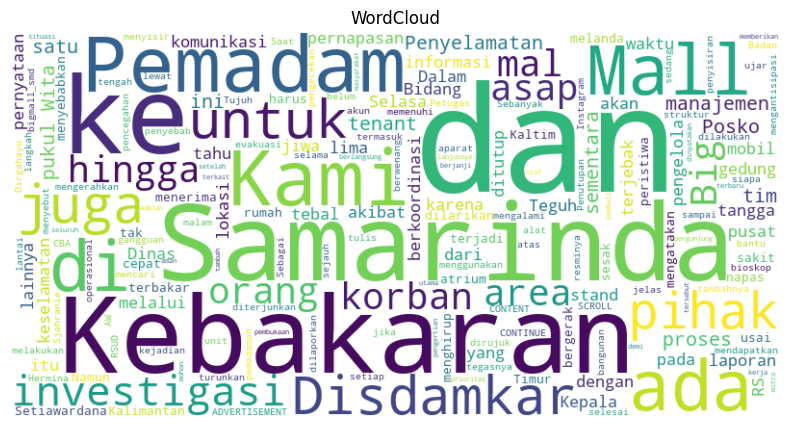

In [ ]:
# Bagian 1: Scraping Data Berita
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os
from bs4 import BeautifulSoup
from wordcloud import WordCloud

os.makedirs('data', exist_ok=True)
os.makedirs('output', exist_ok=True)

url = input("Masukkan URL berita: ")
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
paras = soup.find_all('p')
raw_text = '\n\n'.join([p.get_text() for p in paras])

# Simpan file
with open('data/data-scraping.txt', 'w', encoding='utf-8') as f:
    for para in raw_text.split('\n\n'):
        p = para.strip()
        if p:
            f.write(p + '\n')

print(f"Jumlah kalimat setelah preprocessing: {len(raw_text)}")
# WordCloud
if len(raw_text.strip()) == 0:
    print("Teks kosong! Tidak dapat menemukan teks.")
else:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("WordCloud")
    plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Jumlah kalimat setelah preprocessing: 25


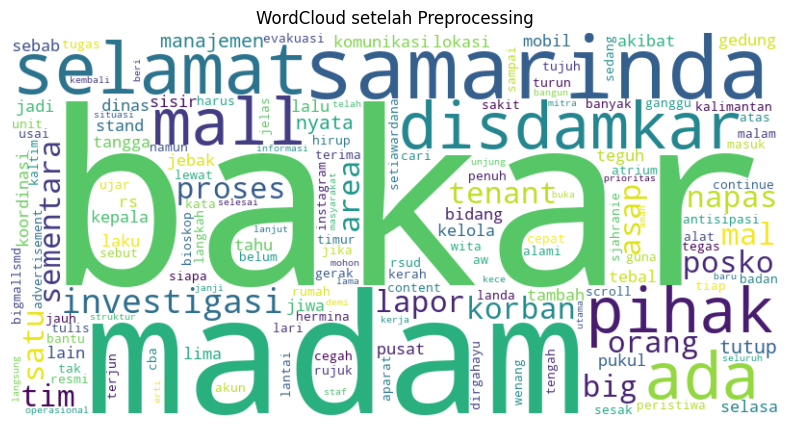

In [18]:
# Bagian 2: Preprocessing 
import re
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

nltk.download('punkt')

with open('data/data-scraping.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()

# Lowercasing
text_lower = raw_text.lower()

# Cleaning HTML, simbol, angka
text_clean = re.sub(r'<.*?>', '', text_lower)
text_clean = re.sub(r'[^a-zA-Z\s\.\?\!]', '', text_clean)
text_clean = re.sub(r'\s+', ' ', text_clean).strip()  

# Tokenisasi Kalimat
sentences = sent_tokenize(text_clean)

# Tokenisasi Kata Stopwords Custom dan Stemmer
custom_stopwords = {
    'berita', 'detikcom', 'artikel', 'kompas', 'cnn', 'com',  
    'juga', 'ini', 'itu', 'dan', 'di', 'ke', 'dari', 'untuk',
    'yang', 'pada', 'dengan', 'sebagai', 'adalah', 'atau',     
    'oleh', 'akan', 'karena', 'tetapi', 'sudah', 'masih',     
    'saat', 'hingga', 'sejak', 'dalam', 'kami', 'anda',        
    'per', 'hingga', 'lebih', 'kurang',                        
    'foto', 'video', 'berikut', 'tersebut',                   
    'hingga', 'dapat', 'tidak', 'atau',                
    'dengan', 'tanpa', 'seperti', 'terkait',                  
    'tanggal', 'waktu', 'jam', 'hari',                        
    'ini', 'itu', 'di', 'ke', 'dari', 'saja', 'kami', 'anda', 
}

stemmer = StemmerFactory().create_stemmer()

filtered_sentences = []
for kalimat in sentences:
    tokens = word_tokenize(kalimat)
    tokens_filtered = [w for w in tokens if w not in custom_stopwords]
    kalimat_bersih = ' '.join(tokens_filtered)
    kalimat_stemmed = stemmer.stem(kalimat_bersih)
    if len(kalimat_stemmed.split()) >= 4:
        filtered_sentences.append(kalimat_stemmed)

# Simpan file
with open('data/data-bersih.txt', 'w', encoding='utf-8') as f:
    for kalimat in filtered_sentences:
        f.write(kalimat.strip() + '\n')

print(f"Jumlah kalimat setelah preprocessing: {len(filtered_sentences)}")

# WordCloud
all_text = ' '.join(filtered_sentences)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud setelah Preprocessing")
plt.show()

In [19]:
# Bagian 4: Pelabelan Otomatis (Heuristik) dan Ekstraksi Fitur TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
n = len(filtered_sentences)
threshold = int(n * 0.2)
labels = [1 if i < threshold else 0 for i in range(n)]
for i, (kalimat, label) in enumerate(zip(filtered_sentences, labels)):
    print(f"{i}: Label={label} - {kalimat}")
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(filtered_sentences)
y = labels

0: Label=1 - bakar landa big mall samarinda kalimantan timur kaltim sebab stand area atrium mal bakar
1: Label=1 - peristiwa tak ada korban jiwa
2: Label=1 - namun orang harus lari rumah sakit akibat sesak napas hirup asap tebal
3: Label=1 - kepala bidang madam selamat disdamkar samarinda teguh setiawardana kata bakar jadi selasa pukul
4: Label=1 - dinas madam bakar selamat disdamkar samarinda gerak cepat usai terima lapor pusat komunikasi
5: Label=0 - wita lalu pusat komunikasi dinas madam bakar ujar kepala bidang madam selamat disdamkar samarinda selasa malam
6: Label=0 - advertisement scroll to continue with content banyak lima posko madam terjun lokasi jadi
7: Label=0 - disdamkar kerah satu unit mobil tangga antisipasi jika ada korban jebak lantai atas gedung
8: Label=0 - posko sampai posko turun
9: Label=0 - mobil tangga stand by lokasi evakuasi jelas teguh
10: Label=0 - tugas laku proses madam sisir pukul
11: Label=0 - tim guna alat bantu napas cba asap tebal penuh area gedung ma

In [20]:
# Bagian 5: Melatih SVM dan Evaluasi Model
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split data training dan testing menjadi 80:20
svm = SVC(kernel='linear', class_weight='balanced') # Untuk mengatur label yang tidak seimbang
svm.fit(X_train, y_train)
scores = cross_val_score(svm, X, y, cv=5) # Iterasi K-Fold 5 kali

y_pred = svm.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Distribusi prediksi:", np.bincount(y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5

Distribusi prediksi: [5]


In [21]:
# Bagian 6: Prediksi Kalimat Penting
y_all_pred = svm.predict(X)
summary_sentences = [sent for sent, label in zip(filtered_sentences, y_all_pred) if label == 1]
summary_text = '\n'.join(summary_sentences)
with open('output/ringkasan.txt', 'w', encoding='utf-8') as f:
    f.write(summary_text)

print("\nRingkasan hasil klasifikasi SVM:")
print(summary_text)


Ringkasan hasil klasifikasi SVM:
peristiwa tak ada korban jiwa
namun orang harus lari rumah sakit akibat sesak napas hirup asap tebal
kepala bidang madam selamat disdamkar samarinda teguh setiawardana kata bakar jadi selasa pukul
dinas madam bakar selamat disdamkar samarinda gerak cepat usai terima lapor pusat komunikasi
wita lalu pusat komunikasi dinas madam bakar ujar kepala bidang madam selamat disdamkar samarinda selasa malam
